In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [136]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [57]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [58]:
def get_timestep_from_data(json_data, pick_frame_every_no):
    timestep = np.zeros([0, dimensions])
    curr_idx = 0
    
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
            continue
        feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
        timestep = np.vstack((timestep, feature))
        curr_idx += 1
        
    return timestep

    

In [59]:
def get_timesteps(json_data, pick_frame_every_no): 
    timesteps = np.zeros([0, dimensions])
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']:
            continue
        feature = get_feature(frame)
        timesteps = np.vstack((timesteps, feature))
    return timesteps

In [114]:
def get_fake_speedup_timesteps_1(percent, json_data, pick_frame_every_no):
    return get_timesteps(json_data, pick_frame_every_no*(100 - percent)//100)

In [151]:
def get_fake_speedup_timesteps_2(percent, old_timesteps, old_pick_frame_every_no):
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_number = old_pick_frame_every_no*(percent - 100)//100
    timesteps_length = old_timesteps.shape[0] // pick_frame_every_no
    
    for new_index in range(timesteps_length):
        start_old_index = (new_index * _pick_frame_every_number) // old_pick_frame_every_no
        x1 = pick_frame_every_number*start_old_index
        x2 = pick_frame_every_number*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        _x = (new_index * pick_frame_every_number)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps
        
    

In [60]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [61]:
pick_frame_every_no = max_frame // 50 + 1

In [144]:
x = np.zeros([0, timesteps, dimensions])
y = np.zeros([0])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)
        
        
        _timesteps = get_fake_speedup_timesteps_1(+10, json_data, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)

array([ 16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,  16.,  16.,  16.,  16.,  17.,  17.,  17.,  17.,
        17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,
        17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,
        17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,
        17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,  17.,
        17.,  17.,  17.,  17.,  17.,  17.,  18.,  18.,  18.,  18.,  18.,
        18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,
        18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,
        18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,
        18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,  18.,
        18.,  18.,  18.,  18.,  18.])

In [145]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [146]:
x_train = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 // 3])
x_test = np.zeros([data_length // 3, timesteps, dimensions])
y_test = np.zeros([data_length // 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx // 3] = x_norm[idx]
        y_test[idx // 3] = y[idx]
    else:
        x_train[idx - idx // 3] = x_norm[idx]
        y_train[idx - idx // 3] = y[idx]

In [147]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 // 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [148]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [149]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [150]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 684 samples, validate on 342 samples
Epoch 1/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.9724 - acc: 0.0468 - val_loss: 2.9447 - val_acc: 0.0468
Epoch 2/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.9649 - acc: 0.0512 - val_loss: 2.9464 - val_acc: 0.0643
Epoch 3/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.9713 - acc: 0.0643 - val_loss: 2.9370 - val_acc: 0.0702
Epoch 4/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.9605 - acc: 0.0526 - val_loss: 2.9449 - val_acc: 0.0526
Epoch 5/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.9647 - acc: 0.0599 - val_loss: 2.9418 - val_acc: 0.0760
Epoch 6/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.9583 - acc: 0.0585 - val_loss: 2.8518 - val_acc: 0.0994
Epoch 7/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.8980 - acc: 0.0702 - val_loss: 2.7660 - val_acc: 0.0906
Epoch 8/1000
684

684/684 [==============================] - 2s 3ms/step - loss: 1.7483 - acc: 0.3787 - val_loss: 1.3835 - val_acc: 0.4912
Epoch 122/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.8248 - acc: 0.3421 - val_loss: 1.4089 - val_acc: 0.4766
Epoch 123/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7808 - acc: 0.3567 - val_loss: 1.3906 - val_acc: 0.4795
Epoch 124/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7617 - acc: 0.3582 - val_loss: 1.3908 - val_acc: 0.4649
Epoch 125/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7094 - acc: 0.3816 - val_loss: 1.3686 - val_acc: 0.5058
Epoch 126/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6942 - acc: 0.3816 - val_loss: 1.3679 - val_acc: 0.5058
Epoch 127/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7241 - acc: 0.3860 - val_loss: 1.3546 - val_acc: 0.4942
Epoch 128/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 1.3171 - acc: 0.5263 - val_loss: 0.9717 - val_acc: 0.6228
Epoch 242/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.3605 - acc: 0.5307 - val_loss: 0.9418 - val_acc: 0.6550
Epoch 243/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.3144 - acc: 0.5249 - val_loss: 0.9602 - val_acc: 0.6579
Epoch 244/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.3937 - acc: 0.4898 - val_loss: 0.9324 - val_acc: 0.6637
Epoch 245/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.3365 - acc: 0.5307 - val_loss: 0.9289 - val_acc: 0.6696
Epoch 246/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.2844 - acc: 0.5205 - val_loss: 0.9375 - val_acc: 0.6667
Epoch 247/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.3663 - acc: 0.5234 - val_loss: 0.9543 - val_acc: 0.6842
Epoch 248/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 1.1194 - acc: 0.5950 - val_loss: 0.7627 - val_acc: 0.7339
Epoch 362/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.1519 - acc: 0.5789 - val_loss: 0.7631 - val_acc: 0.7368
Epoch 363/1000
684/684 [==============================] - 2s 4ms/step - loss: 1.1118 - acc: 0.6170 - val_loss: 0.7271 - val_acc: 0.7573
Epoch 364/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.0809 - acc: 0.6038 - val_loss: 0.7396 - val_acc: 0.7515
Epoch 365/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.1332 - acc: 0.5702 - val_loss: 0.7216 - val_acc: 0.7602
Epoch 366/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.1377 - acc: 0.5980 - val_loss: 0.7468 - val_acc: 0.7398
Epoch 367/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.1481 - acc: 0.5980 - val_loss: 0.7436 - val_acc: 0.7485
Epoch 368/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.9960 - acc: 0.6360 - val_loss: 0.6249 - val_acc: 0.7865
Epoch 482/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.0006 - acc: 0.6447 - val_loss: 0.6167 - val_acc: 0.7836
Epoch 483/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.9900 - acc: 0.6213 - val_loss: 0.6017 - val_acc: 0.7895
Epoch 484/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.9474 - acc: 0.6579 - val_loss: 0.6211 - val_acc: 0.7807
Epoch 485/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.0529 - acc: 0.6360 - val_loss: 0.6274 - val_acc: 0.7749
Epoch 486/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.0352 - acc: 0.6301 - val_loss: 0.5940 - val_acc: 0.7953
Epoch 487/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.9750 - acc: 0.6520 - val_loss: 0.5993 - val_acc: 0.7865
Epoch 488/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 2s 3ms/step - loss: 0.9420 - acc: 0.6711 - val_loss: 0.5470 - val_acc: 0.8187
Epoch 602/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8724 - acc: 0.6871 - val_loss: 0.5506 - val_acc: 0.8129
Epoch 603/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.9131 - acc: 0.6842 - val_loss: 0.5462 - val_acc: 0.8041
Epoch 604/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.9556 - acc: 0.6594 - val_loss: 0.5582 - val_acc: 0.8129
Epoch 605/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.9114 - acc: 0.6842 - val_loss: 0.5592 - val_acc: 0.8099
Epoch 606/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.9457 - acc: 0.6667 - val_loss: 0.5598 - val_acc: 0.8187
Epoch 607/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8805 - acc: 0.6740 - val_loss: 0.5475 - val_acc: 0.8158
Epoch 608/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.8750 - acc: 0.7178 - val_loss: 0.5079 - val_acc: 0.8246
Epoch 722/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8618 - acc: 0.7047 - val_loss: 0.5041 - val_acc: 0.8246
Epoch 723/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8278 - acc: 0.7061 - val_loss: 0.4993 - val_acc: 0.8275
Epoch 724/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8076 - acc: 0.7032 - val_loss: 0.4979 - val_acc: 0.8246
Epoch 725/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8671 - acc: 0.6915 - val_loss: 0.5035 - val_acc: 0.8275
Epoch 726/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8456 - acc: 0.7076 - val_loss: 0.5147 - val_acc: 0.8158
Epoch 727/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8970 - acc: 0.6886 - val_loss: 0.5142 - val_acc: 0.8275
Epoch 728/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.7800 - acc: 0.7193 - val_loss: 0.4758 - val_acc: 0.8304
Epoch 842/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7983 - acc: 0.7354 - val_loss: 0.4743 - val_acc: 0.8304
Epoch 843/1000
684/684 [==============================] - 2s 4ms/step - loss: 0.7997 - acc: 0.7295 - val_loss: 0.4669 - val_acc: 0.8363
Epoch 844/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8043 - acc: 0.7281 - val_loss: 0.4576 - val_acc: 0.8421
Epoch 845/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8057 - acc: 0.7135 - val_loss: 0.4573 - val_acc: 0.8392
Epoch 846/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7737 - acc: 0.7251 - val_loss: 0.4606 - val_acc: 0.8363
Epoch 847/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8498 - acc: 0.7105 - val_loss: 0.4644 - val_acc: 0.8363
Epoch 848/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 0.7159 - acc: 0.7368 - val_loss: 0.4457 - val_acc: 0.8480
Epoch 962/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7363 - acc: 0.7412 - val_loss: 0.4436 - val_acc: 0.8567
Epoch 963/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7320 - acc: 0.7398 - val_loss: 0.4438 - val_acc: 0.8450
Epoch 964/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7881 - acc: 0.7120 - val_loss: 0.4505 - val_acc: 0.8538
Epoch 965/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.8080 - acc: 0.7061 - val_loss: 0.4405 - val_acc: 0.8567
Epoch 966/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7774 - acc: 0.7398 - val_loss: 0.4458 - val_acc: 0.8596
Epoch 967/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.7201 - acc: 0.7485 - val_loss: 0.4366 - val_acc: 0.8626
Epoch 968/1000
684/684 [==============================] - 2s 3m

In [152]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

342/342 [==============================] - 0s 246us/step
Test score: 0.431700981848
Test accuracy: 0.847953216026


In [153]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


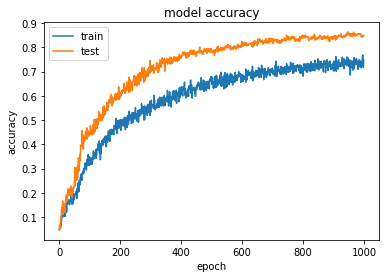

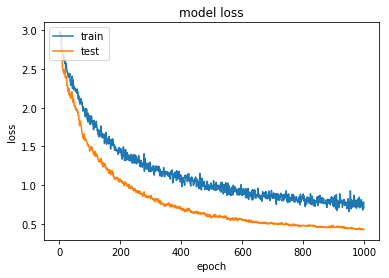

In [154]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()